# 1 Instalación de surprise por medio del terminal de anaconda con derechos de administrador
## Se introduce la instrucción conda install -c conda-forge scikit-surprise

Surprise requiere python 3.10.x no funciona con versiones inferiores o superiores.
Se adpata también en consola, instalando un nuevo entron envsurprise con python 3.10.
después de activar el nuevo entorno se carga ipykernel
Finalmente, se cambia el entorno en Cambiar Kernel

In [1]:
# Comprobar la version de python
import sys
print (sys.version)

3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


# 2 Instalación de librerías necesarias

In [56]:
# Importación de módulos especificos de surprise
from surprise import Dataset, Reader
from surprise import accuracy as surprise_accuracy
from surprise import SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate

# Importación de otras liberías útiles
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import heapq
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules

# 3 Importación de datos de movilens
## Para mayor simplicidad se ha importado los datos en el fichero dataset.csv con los campos siguientes:
* userId
* movieId
* Title
* rating

In [24]:
#df = pd.read_csv('dataset.csv', on_bad_lines='warn', skiprows=lambda i: i>0 and random.random() > 0.001)
df = pd.read_csv('dataset.csv', sep= ';')
print(df[:4])
print(df.columns)
print(len(df))

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
Index(['userId', 'movieId', 'rating'], dtype='object')
100836


In [25]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(df[['userId','movieId','rating']],reader)
print(type(data))
#reader = Reader(line_format='user item rating', sep=';')
#data = Dataset.load_from_file('dataset.csv', reader=reader)

<class 'surprise.dataset.DatasetAutoFolds'>


# 4 División del fichero entre entrenamiento y test

In [27]:
    # test_size=0.2 significa que 20%  de los datos servirá para el test
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    print(f"\nTraining set size: {len(list(trainset.all_ratings()))}")
    print(f"Test set size: {len(testset)}")


Training set size: 80668
Test set size: 20168


# 5 Entrenamiento del modelo SVD

In [28]:
    print("\n Entrenando al modelo SVD...")
    
    svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
    svd.fit(trainset)


 Entrenando al modelo SVD...


# 6 Evaluación del modelo en el set de test

In [34]:
    predictions = svd.test(testset)
    rmse = surprise_accuracy.rmse(predictions)
    mae = surprise_accuracy.mae(predictions)
    
    print(f"Evaluación del modelo en el set de test:")
    print(f"RMSE: {rmse:.4f}") # RMSE (Root Mean Square Error): valores bajos indican un mejor resultado
    print(f"MAE: {mae:.4f}") # MAE (Mean Absolute Error): medida de la exactitud de la predicción

RMSE: 0.8822
MAE:  0.6779
Evaluación del modelo en el set de test:
RMSE: 0.8822
MAE: 0.6779


# 7 Función para obtener las N mejores recomendaciones para un usuario

In [35]:
    def get_top_n_recommendations(predictions, n=10):
        """Devuelve las n mejores recomendaciones para cada usuario
        en este caso las 10 mejores"""
        # Diccionario con las predicciones para cada usuario
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
            
        # Se ordenan las predicciones para cada usuario y se encuentran las mejores
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
            
        return top_n

# 8 Función para generar recomendaciones para un usuario

In [36]:
    
    def recommend_for_user(user_id, n=10):
        """Crea n recommendaciones para un usuario espedífico"""
        # Obtener la lista de todos los identificadores de películas
        all_movie_ids = ratings_df['movieId'].unique()
        
        # Obeter los identificadores de las películas que el usuario ya ha visto
        user_rated_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
        
        # Identificadores de las películas que el usuario no ha visto para hacer predicciones
        movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]
        
        # Hacer predicciones
        predictions = [svd.predict(user_id, movie_id) for movie_id in movies_to_predict]
        
        # Ordenar las predicciones usanto evaluaciones estimadas
        predictions.sort(key=lambda x: x.est, reverse=True)
        
        # Guardar las n mejores y devolverlas
        top_recommendations = predictions[:n]
        
        return top_recommendations

# 9 Predicción para un usuario determinado 

In [39]:
    ratings_df = df
    # Escoger un usuario del dataset
    sample_user = ratings_df['userId'].iloc[0]
    print(f"\nGenerando recommendaciones para el user {sample_user}...")
    movie_titles = {}
    recommendations = recommend_for_user(sample_user, n=10)
    
    print(f"\n 10 películas recommendadas para el usuario {sample_user}:")
    for i, rec in enumerate(recommendations, 1):
        movie_id = rec.iid
        predicted_rating = rec.est
        title = movie_titles.get(movie_id, f"Identificador de la película: {movie_id}")
        print(f"{i}. {title} (Evaluación prevista: {predicted_rating:.2f})")
    


Generando recommendaciones para el user 1...

 10 películas recommendadas para el usuario 1:
1. Identificador de la película: 1272 (Evaluación prevista: 5.00)
2. Identificador de la película: 1283 (Evaluación prevista: 5.00)
3. Identificador de la película: 7153 (Evaluación prevista: 5.00)
4. Identificador de la película: 1276 (Evaluación prevista: 5.00)
5. Identificador de la película: 4973 (Evaluación prevista: 5.00)
6. Identificador de la película: 3435 (Evaluación prevista: 5.00)
7. Identificador de la película: 3275 (Evaluación prevista: 5.00)
8. Identificador de la película: 1204 (Evaluación prevista: 5.00)
9. Identificador de la película: 246 (Evaluación prevista: 5.00)
10. Identificador de la película: 1172 (Evaluación prevista: 5.00)


# 10 Archivar el modelo para usos futuros

In [40]:
    import pickle
    with open('svd_model.pkl', 'wb') as file:
        pickle.dump(svd, file)
    
    print("\nModelo guradado como 'svd_model.pkl'")


Modelo guradado como 'svd_model.pkl'


# 11 Añadir un nuevo usuario para efectuar recomendaciones

In [47]:
nuevo_df = df
nuevo_df.loc[100837] = ['611','1','4.7']
nuevo_df.loc[100838] = ['611','552','4.3']
nuevo_df.loc[100839] = ['611','88267','4.5']
nuevo_df.loc[100840] = ['611','1270','4.0']
nuevo_df.loc[100841] = ['611','59614','4.0']
nuevo_df.loc[100842] = ['611','30793','4.5']


print (nuevo_df[100837:100842])


       userId movieId rating
100838    611     552    4.3
100839    611   88267    4.5
100840    611    1270    4.0
100841    611   59614    4.0
100842    611   30793    4.5


In [49]:
# Escoger el usuario añadido al dataset
sample_user = nuevo_df['userId'].iloc[611]
print(f"\nGenerando recommendaciones para el user {sample_user}...")
movie_titles = {}
recommendations = recommend_for_user(sample_user, n=10)
    
print(f"\n 10 películas recommendadas para el usuario {sample_user}:")
for i, rec in enumerate(recommendations, 1):
    movie_id = rec.iid
    predicted_rating = rec.est
    title = movie_titles.get(movie_id, f"Identificador de la película: {movie_id}")
    print(f"{i}. {title} (Evaluación prevista: {predicted_rating:.2f})")
    


Generando recommendaciones para el user 6...

 10 películas recommendadas para el usuario 6:
1. Identificador de la película: 1204 (Evaluación prevista: 4.67)
2. Identificador de la película: 1235 (Evaluación prevista: 4.56)
3. Identificador de la película: 741 (Evaluación prevista: 4.50)
4. Identificador de la película: 1276 (Evaluación prevista: 4.45)
5. Identificador de la película: 31658 (Evaluación prevista: 4.44)
6. Identificador de la película: 5952 (Evaluación prevista: 4.44)
7. Identificador de la película: 1252 (Evaluación prevista: 4.43)
8. Identificador de la película: 119145 (Evaluación prevista: 4.42)
9. Identificador de la película: 969 (Evaluación prevista: 4.42)
10. Identificador de la película: 1356 (Evaluación prevista: 4.42)


# 12 Se usan los datos nuevamente para el clustering usando usuario, id película y valoración

In [51]:
#1. Crear matriz usuario-película
# Convertir userId, movieId y rating al tipo apropiado to appropriate types if they aren't already
nuevo_df['userId'] = nuevo_df['userId'].astype(int)
nuevo_df['movieId'] = nuevo_df['movieId'].astype(int)
nuevo_df['rating'] = nuevo_df['rating'].astype(float) 

user_movie_matrix = nuevo_df.pivot_table(
    index="userId",
    columns="movieId",
    values="rating",
    aggfunc='mean'
).fillna(0)


In [52]:
# 2. Estandarización de los datos:
# Se hace la estandrización pqra que cada película tenga una media 0 y una desviación estándar 1.
# Esto evita que haya películas con mucha nota que prevalezcan en el cluster.

scaler = StandardScaler()
user_movie_scaled = scaler.fit_transform(user_movie_matrix)

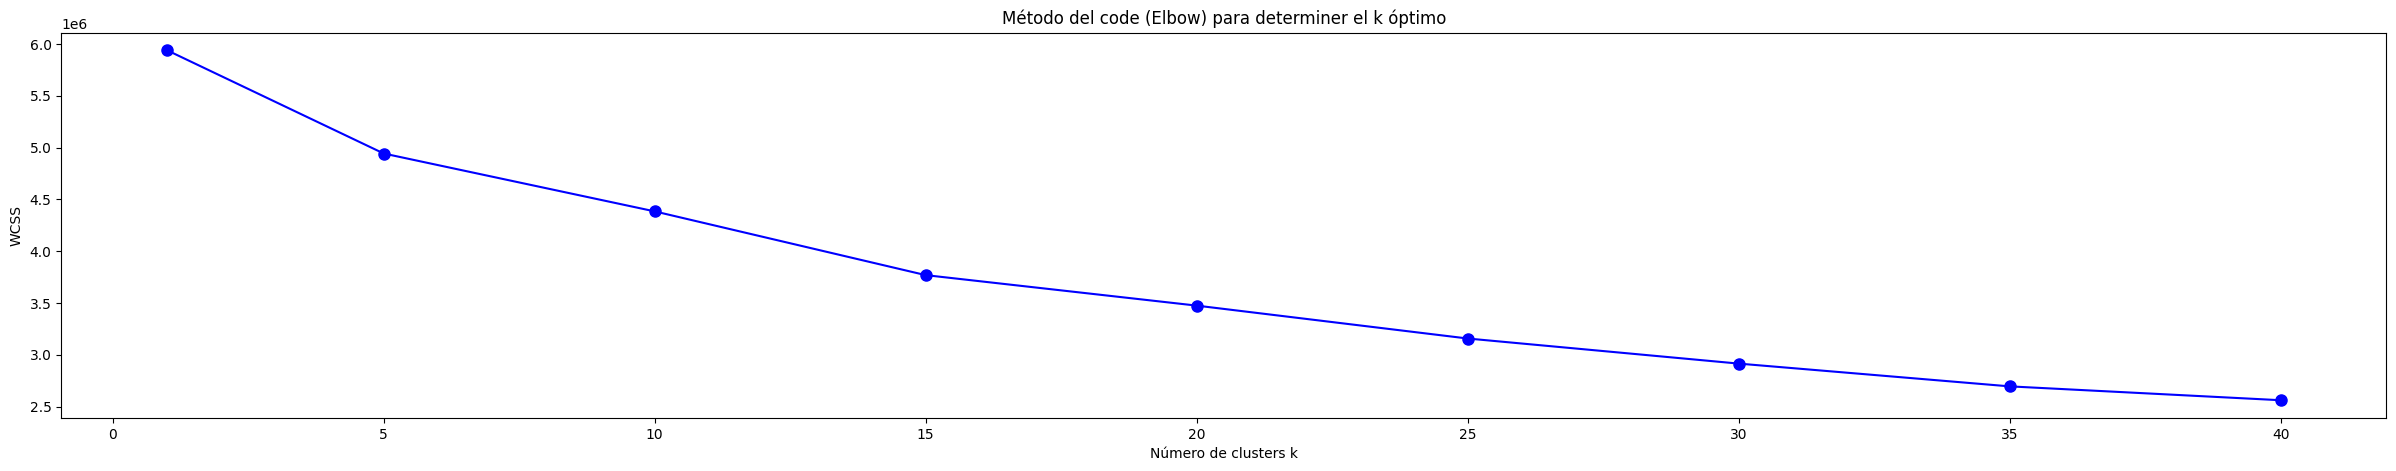

In [57]:
# 3. Determinar el mejor valor de k
wcss = []
K_range = [1,5,10,15,20,25,30,35,40] # Se define un número razonable de clusters que puedan servir

# Se calculan los datos de cluster y centroides
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(user_movie_scaled)
    wcss.append(kmeans.inertia_)

# Visualización del "codo" que indica el mejor k
plt.figure(figsize=(30,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Número de clusters k')
plt.ylabel('WCSS')
plt.title('Método del code (Elbow) para determiner el k óptimo')
plt.show()

In [54]:
# 4. Aplicar K-Means

n_clusters = 40  # número de clusters ideal, ver 4. 
# A partir del codo 16  Wcss disminuye lentamente y no hay ganancia al añadir más
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_movie_scaled)

# Añadir los centroides de los clusters a los usuarios utilisateurs
user_clusters = pd.DataFrame({
    "user_id": user_movie_matrix.index,
    "cluster": clusters
})

# Comprobar el número de usuarios por cluster
print("Cantidad de usuarios por cluster :")
print(user_clusters["cluster"].value_counts())

C:\ProgramData\anaconda3\envs\envsurprise\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cantidad de usuarios por cluster :
cluster
1     534
29     39
0       1
28      1
3       1
30      1
2       1
5       1
25      1
13      1
38      1
39      1
34      1
21      1
27      1
7       1
23      1
14      1
10      1
15      1
33      1
9       1
6       1
35      1
26      1
31      1
16      1
12      1
20      1
37      1
17      1
8       1
18      1
22      1
11      1
19      1
36      1
24      1
32      1
4       1
Name: count, dtype: int64


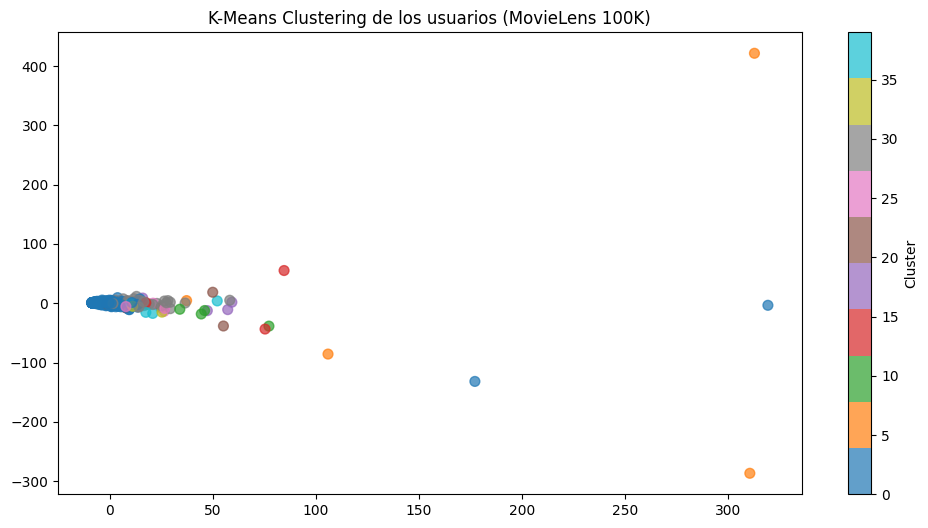

In [58]:
# 4. Reducción de la dimensión para su visualisación en dos dimensiones (usando PCA)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_movie_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=clusters,
    cmap="tab10",
    s=50,
    alpha=0.7
)
plt.title("K-Means Clustering de los usuarios (MovieLens 100K)")
plt.xlabel("")
plt.ylabel("")
plt.colorbar(label="Cluster")
plt.show()